In [114]:
'''data'''
import pandas as pd
import numpy as np
import re

%run helpers.ipynb

'''plots'''
import matplotlib.pyplot as plt 
import seaborn as sns

'''keras'''
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from keras.layers import Dropout, concatenate
from keras.layers.core import Reshape
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers

'''Gensim'''
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors


'''metrics'''
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split

**In general, pre-trained word embeddings are particularly useful on problems where there is very little training data (otherwise, I should train my word-embeddings on the corpus).  This is suitable to requirement classification since we usually don't have a large set of labelled data.  The labelling of software requirements need to be done manually by individual with domain expertise; thus even at Logapps, we only had a train dataset (labelled by trained interns in the previous summers) of about 5000 samples.**

## Import data
- Import the processed data from part 1 and part 2

In [115]:
SecReq = pd.read_csv("../processed_data/SecReq_processed.csv")
nfr = pd.read_csv("../processed_data/nfr_processed.csv")
nfr_binary = pd.read_csv("../processed_data/nfr_binary_processed.csv")

## Process text
- We no longer need to identify bigrams and trigrams using Phrase models ourselves since we are using CNN models.  We can define filters of size 2 and 3 (bigrams and trigrams) and during training, CNN will automatically (using backpropogation) extract/identify features (two or three word phrases) that are informative in predicting the class of the requirements.  

In [116]:
# remove all functional class, I am only interested in classifying non-functional requirements to their subtypes
nfr = nfr.loc[nfr.labels!="F", :] 

In [117]:
SecReq = SecReq[["text", "labels_num"]]
nfr = nfr[["text","labels_num"]]
nfr_binary = nfr_binary[["text","labels_num"]]

In [118]:
SecReq.shape, nfr.shape, nfr_binary.shape

((471, 2), (370, 2), (625, 2))

**We have very small dataset (even smaller than the one I had at Logapps).  Hopefully, we can overcome this weakness with transfer-learning: using pre-trained word embeddings to learn "generic low-level features" and only focus on learning high level features with my small dataset.  We are very likely going to have overfitting problems with all our CNN models.**

## Load the word2vec pre-trained word embeddings

In [119]:
%%time
execute = True

if execute:
    # Load KeyedVectors for the Google News word embeddings
    # Contains 3 million 300-D word embeddings trained from 100 billion words

    # Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
    # The vectors is loaded from an existing file on disk in the original Google’s word2vec C format as 
    # a KeyedVectors instance
    word_vectors = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', 
                                                                binary=True) # C bin format

Wall time: 6min 28s


## Let's start with binary classification with the SecReq dataset

**Process the text and build the embedding matrix**

In [120]:
texts = SecReq["text"]
labels = SecReq["labels_num"] 

X_train, X_val, y_train, y_val, embedding_matrix = keras_processing(texts, labels, max_words=1000, maxlen= 75) 

Found 1310 unique tokens.

The shape of the data tensor is: (471, 75)

The shape of the label tensor is: (471, 2)


## Modelling
- As per Kim Yoon's "Convolutional Neural Networks for Sentence Classification", we will only use conv layer to extract features using filter_size 1,2 and 3.
- The size of the filter is (filter_size, embeding_dim). If filter_size = 1, I will only extract unigram features; and if filter_size=2, I will extract bigrams features.
- I will use 1-max pooling to get the max value of the feature map of each filter.
- Thus, if I have 6 filters, I will get a 6x1 vector after the 1-max pooling.
- Finally, I will have a fully connected layer and softmax layer.

**Settings**

In [121]:
sequence_length = X_train.shape[1] # number of words in each doc
filter_sizes = [1,2] # filter size for conv layer 1, and for conv layer 2  (consider unigrams and bigrams)
num_filters = 128 # number of filters for each conv layer
drop = 0.5  # probability of dropping neurons

vocabulary_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

**Embedding layer**

In [122]:
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

**Build model**

In [123]:
# The input to the embeddings layer for each doc is bascially an array of word index of length "sequence_length",
# the length of each doc
inputs = Input(shape=(sequence_length,))
# Emedding layer:
    # Input: word index of shape (75,)
    # output: a 3D tensor of shape (samples, sequence_length, embedding_dim) = (samples, 75, 300)
embedding = embedding_layer(inputs)
# reshape the output of the embedding layer to shape (75, 300, 1 )
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)  

# conv layer 1 (use filter window size 1: extract unigrams)
# input is the "reshaped" embedding matrix
conv_0 = Conv2D(num_filters, # number of filters (50) 
                (filter_sizes[0], embedding_dim), # shape of the filter 
                activation='relu', # activation function
                # Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. 
                # These penalties are summed into the loss function that the network optimizes.
                kernel_regularizer=regularizers.l2(0.01))(reshape)

# conv layer 2 (use filter window size 2: extract bigrams)
# input is the "reshaped" embedding matrix
conv_1 = Conv2D(num_filters, 
                (filter_sizes[1], embedding_dim),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(reshape)

# Apply max pooling to the activation maps (100 of them) for EACH conv layer
# sequence_length - filter_sizes[0] + 1 is the length of Each feature map
maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0) # size of 1x100
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

# I get a feature from each of the 1-max pooling layer, so I have 2 features in total
# I concat the features to get a 2 feature vector of size 2x100
merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1) 
flatten = Flatten()(merged_tensor) 

dropout = Dropout(drop)(flatten)
output = Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [124]:
# Creates a model class with takes a Keras.Input object and the outputs of the model as argument
model = Model(inputs, output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 75, 300)      300000      input_4[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 75, 300, 1)   0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 75, 1, 128)   38528       reshape_4[0][0]                  
____________________________________________________________________________________________

**Train model**

In [125]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(X_train, y_train,
                   epochs = 30,
                   batch_size = 64,
                   validation_data = (X_val, y_val))

Train on 376 samples, validate on 95 samples
Epoch 1/30
376/376 [==============================] - 6s 15ms/step - loss: 0.6988 - accuracy: 0.6529 - val_loss: 0.6397 - val_accuracy: 0.7263
Epoch 2/30
376/376 [==============================] - 1s 2ms/step - loss: 0.6085 - accuracy: 0.7593 - val_loss: 0.5978 - val_accuracy: 0.8158
Epoch 3/30
376/376 [==============================] - 1s 2ms/step - loss: 0.5547 - accuracy: 0.8497 - val_loss: 0.5702 - val_accuracy: 0.7579
Epoch 4/30
376/376 [==============================] - 1s 2ms/step - loss: 0.5316 - accuracy: 0.8391 - val_loss: 0.5517 - val_accuracy: 0.7789
Epoch 5/30
376/376 [==============================] - 1s 2ms/step - loss: 0.4989 - accuracy: 0.8750 - val_loss: 0.5437 - val_accuracy: 0.8053
Epoch 6/30
376/376 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.8883 - val_loss: 0.5368 - val_accuracy: 0.7947
Epoch 7/30
376/376 [==============================] - 1s 2ms/step - loss: 0.4670 - accuracy: 0.9029 - 

## Plot

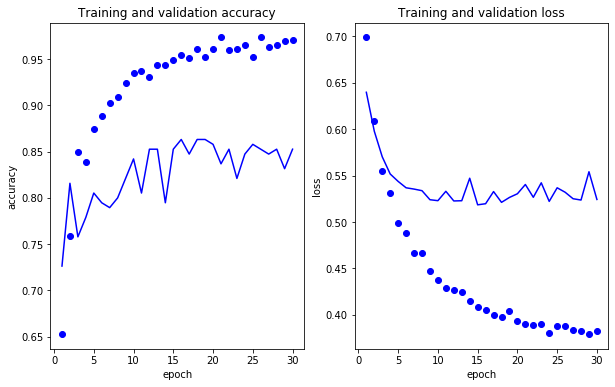

In [126]:
# Plot model performance over epochs
train_acc = history.history["accuracy"] # train accuracy of each of the 10 train epoch
validation_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(1,len(train_acc)+1,1)

fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(epochs, train_acc, 'bo', label = "Training acc")
axes[0].plot(epochs,validation_acc, 'b', label = "Validation acc")
axes[0].set_title("Training and validation accuracy")
axes[0].set_ylabel("accuracy")
axes[0].set_xlabel("epoch")


axes[1].plot(epochs, train_loss, 'bo', label = "Training loss")
axes[1].plot(epochs,validation_loss, 'b', label = "Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].set_ylabel("loss")
axes[1].set_xlabel("epoch")

plt.show()

**Results**

In [127]:
# Empty lists of model name and model performance metrics
model_name, acc_score_list, precision_score_list, recall_score_list, f1_score_list = [], [], [], [], []

In [128]:
# make predictions
y_pred = model.predict(X_val)
# Get the predicted class by taking the max probability
y_pred_classes = np.argmax(y_pred,axis=1)
# Get the predicted classes of y_val
y_val_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
y_val_classes = np.asarray(y_val_classes)

In [129]:
# Update model performance lists

# Model performance
acc_score_list.append(accuracy_score(y_val_classes, y_pred_classes))
# compute precision of each class and take average
precision_score_list.append(precision_score(y_val_classes, y_pred_classes)) 
recall_score_list.append(recall_score(y_val_classes, y_pred_classes))
f1_score_list.append(f1_score(y_val_classes, y_pred_classes))
# model name
model_name.append("CNN (SeqReq)")

In [130]:
print(f"model name: CNN(SeqReq) \n \
      accuracy: {accuracy_score(y_val_classes, y_pred_classes)} \n \
      precision: {precision_score(y_val_classes, y_pred_classes)} \n \
      recall: {recall_score(y_val_classes, y_pred_classes)} \n \
      f1: {f1_score(y_val_classes, y_pred_classes)}")

model name: CNN(SeqReq) 
       accuracy: 0.8526315789473684 
       precision: 0.8571428571428571 
       recall: 0.7058823529411765 
       f1: 0.7741935483870968


## Binary classification with the nfr_binary dataset

**Process the text and build the embedding matrix**

In [131]:
nfr_binary.head()

,text,labels_num
0,The system shall refresh the display every 60 ...,1
1,The application shall match the color of the s...,1
2,If projected the data must be readable. On ...,1
3,The product shall be available during normal ...,1
4,If projected the data must be understandable...,1


In [132]:
texts = nfr_binary["text"]
labels = nfr_binary["labels_num"] 

X_train, X_val, y_train, y_val, embedding_matrix = keras_processing(texts, labels, max_words=1000, maxlen= 75) 

Found 1697 unique tokens.

The shape of the data tensor is: (625, 75)

The shape of the label tensor is: (625, 2)


**Modelling**

In [133]:
sequence_length = X_train.shape[1] # number of words in each doc
filter_sizes = [1,2] # filter size for conv layer 1, and for conv layer 2  (consider unigrams and bigrams)
num_filters = 64 # number of filters for each conv layer
drop = 0.5  # probability of dropping neurons

vocabulary_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

In [134]:
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

In [135]:
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)  
conv_0 = Conv2D(num_filters, 
                (filter_sizes[0], embedding_dim),  
                activation='relu', 
                kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, 
                (filter_sizes[1], embedding_dim),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(reshape)
maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0) # size of 1x100
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1) 
flatten = Flatten()(merged_tensor) 
dropout = Dropout(drop)(flatten)
output = Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [136]:
# Creates a model class with takes a Keras.Input object and the outputs of the model as argument
model = Model(inputs, output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 75, 300)      300000      input_5[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 75, 300, 1)   0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 75, 1, 64)    19264       reshape_5[0][0]                  
____________________________________________________________________________________________

**Train Model**

In [137]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(X_train, y_train,
                   epochs = 100,
                   batch_size = 64,
                   validation_data = (X_val, y_val),
                   verbose = 0)

Wall time: 1min 3s


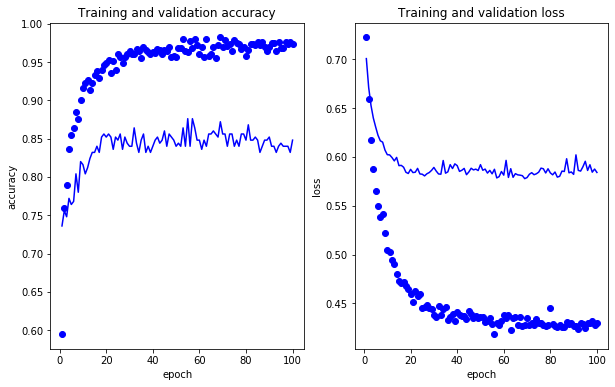

In [138]:
# Plot model performance over epochs
train_acc = history.history["accuracy"] # train accuracy of each of the 10 train epoch
validation_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(1,len(train_acc)+1,1)

fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(epochs, train_acc, 'bo', label = "Training acc")
axes[0].plot(epochs,validation_acc, 'b', label = "Validation acc")
axes[0].set_title("Training and validation accuracy")
axes[0].set_ylabel("accuracy")
axes[0].set_xlabel("epoch")


axes[1].plot(epochs, train_loss, 'bo', label = "Training loss")
axes[1].plot(epochs,validation_loss, 'b', label = "Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].set_ylabel("loss")
axes[1].set_xlabel("epoch")

plt.show()

**Results**

In [139]:
# make predictions
y_pred = model.predict(X_val)
# Get the predicted class by taking the max probability
y_pred_classes = np.argmax(y_pred,axis=1)
# Get the predicted classes of y_val
y_val_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
y_val_classes = np.asarray(y_val_classes)

In [140]:
# Update model performance lists

# Model performance
acc_score_list.append(accuracy_score(y_val_classes, y_pred_classes))
# compute precision of each class and take average
precision_score_list.append(precision_score(y_val_classes, y_pred_classes)) 
recall_score_list.append(recall_score(y_val_classes, y_pred_classes))
f1_score_list.append(f1_score(y_val_classes, y_pred_classes))
# model name
model_name.append("CNN (nfr_binary)")

In [141]:
print(f"model name: CNN(nfr_binary) \n \
      accuracy: {accuracy_score(y_val_classes, y_pred_classes)} \n \
      precision: {precision_score(y_val_classes, y_pred_classes)} \n \
      recall: {recall_score(y_val_classes, y_pred_classes)} \n \
      f1: {f1_score(y_val_classes, y_pred_classes)}")

model name: CNN(nfr_binary) 
       accuracy: 0.848 
       precision: 0.8313253012048193 
       recall: 0.9324324324324325 
       f1: 0.8789808917197452


## Multi-class classification with the nfr dataset

**Process the text and build the embedding matrix**

In [142]:
nfr.head()

,text,labels_num
0,The system shall refresh the display every 60 ...,3
1,The application shall match the color of the s...,1
2,If projected the data must be readable. On ...,5
3,The product shall be available during normal ...,6
4,If projected the data must be understandable...,5


In [143]:
texts = nfr["text"]
labels = nfr["labels_num"] -1 # shift all labels_num to the left

X_train, X_val, y_train, y_val, embedding_matrix = keras_processing(texts, labels, max_words=1000, maxlen= 75) 

Found 1338 unique tokens.

The shape of the data tensor is: (370, 75)

The shape of the label tensor is: (370, 6)


**Modelling**

In [144]:
sequence_length = X_train.shape[1] # number of words in each doc
filter_sizes = [1,2] # filter size for conv layer 1, and for conv layer 2  (consider unigrams and bigrams)
num_filters = 64 # number of filters for each conv layer
drop = 0.5  # probability of dropping neurons

vocabulary_size = embedding_matrix.shape[0]
embedding_dim = embedding_matrix.shape[1]

In [145]:
embedding_layer = Embedding(vocabulary_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

In [146]:
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)  
conv_0 = Conv2D(num_filters, 
                (filter_sizes[0], embedding_dim),  
                activation='relu', 
                kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, 
                (filter_sizes[1], embedding_dim),
                activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(reshape)
maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0) # size of 1x100
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1) 
flatten = Flatten()(merged_tensor) 
dropout = Dropout(drop)(flatten)
output = Dense(6, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [147]:
# Creates a model class with takes a Keras.Input object and the outputs of the model as argument
model = Model(inputs, output)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 75, 300)      300000      input_6[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 75, 300, 1)   0           embedding_6[0][0]                
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 75, 1, 64)    19264       reshape_6[0][0]                  
____________________________________________________________________________________________

**Train Model**

In [148]:
%%time
# compile and train the network
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Use early stopping
# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(X_train, y_train,
                   epochs = 140,
                   batch_size = 128,
                   validation_data = (X_val, y_val),
                   verbose = 0)

Wall time: 49 s


**Plot**

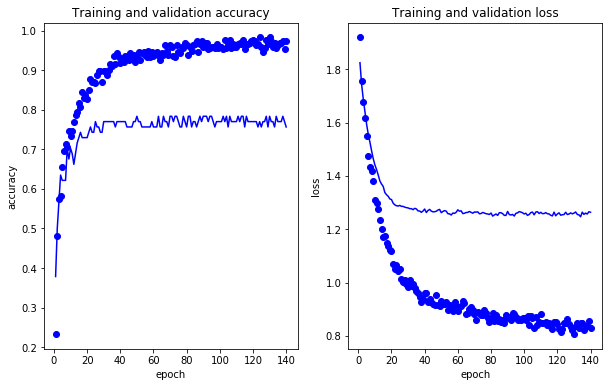

In [149]:
# Plot model performance over epochs
train_acc = history.history["accuracy"] # train accuracy of each of the 10 train epoch
validation_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(1,len(train_acc)+1,1)

fig, axes = plt.subplots(1,2, figsize=(10,6))
axes[0].plot(epochs, train_acc, 'bo', label = "Training acc")
axes[0].plot(epochs,validation_acc, 'b', label = "Validation acc")
axes[0].set_title("Training and validation accuracy")
axes[0].set_ylabel("accuracy")
axes[0].set_xlabel("epoch")


axes[1].plot(epochs, train_loss, 'bo', label = "Training loss")
axes[1].plot(epochs,validation_loss, 'b', label = "Validation loss")
axes[1].set_title("Training and validation loss")
axes[1].set_ylabel("loss")
axes[1].set_xlabel("epoch")

plt.show()

**Results**

In [150]:
model.evaluate(X_val, y_val)

74/74 [==============================] - 0s 446us/step


[1.2637582083006162, 0.7567567825317383]

In [151]:
# make predictions
y_pred = model.predict(X_val)
# Get the predicted class by taking the max probability
y_pred_classes = np.argmax(y_pred,axis=1)
# Get the predicted classes of y_val
y_val_classes = [np.argmax(y, axis=None, out=None) for y in y_val]
y_val_classes = np.asarray(y_val_classes)

In [152]:
# Update model performance lists
acc = accuracy_score(y_val_classes, y_pred_classes)
precision = precision_score(y_val_classes, y_pred_classes, average="macro")
recall = recall_score(y_val_classes, y_pred_classes,average="macro")
f1 = f1_score(y_val_classes, y_pred_classes,average="macro")

# Model performance
acc_score_list.append(acc)
# compute precision of each class and take average
precision_score_list.append(precision) 
recall_score_list.append(recall)
f1_score_list.append(f1)
# model name
model_name.append("CNN (nfr_multiclass)")

In [153]:
print(f"model name: CNN(nfr_multiclass) \n \
      accuracy: {acc} \n \
      precision: {precision} \n \
      recall: {recall} \n \
      f1: {f1}") 

model name: CNN(nfr_multiclass) 
       accuracy: 0.7567567567567568 
       precision: 0.8142156862745099 
       recall: 0.7484802778920426 
       f1: 0.7615158247206928


**Confusion matrix**

In [154]:
conf_mat = confusion_matrix(y_val_classes, y_pred_classes)
conf_mat

array([[ 4,  2,  0,  0,  2,  0],
       [ 0, 10,  0,  0,  1,  1],
       [ 0,  0,  9,  0,  0,  2],
       [ 0,  1,  0, 11,  0,  1],
       [ 0,  0,  0,  0, 11,  2],
       [ 0,  4,  0,  1,  1, 11]], dtype=int64)

**The diagonal elements are correctly predicted by the model.  I see small off-diagonal values.**

In [155]:
label_dict = {"LF":0, "O":1, "PE":2, "SE":3, "US":4, "others":5} # mapping of labels and label_num

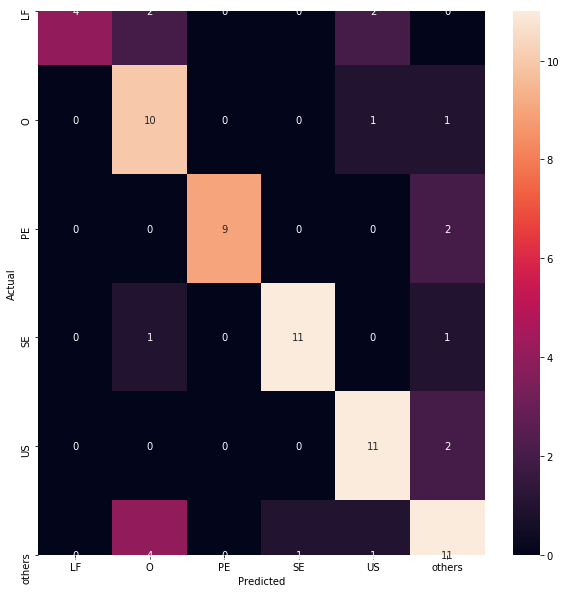

In [156]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=list(label_dict.keys()),  yticklabels=list(label_dict.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig("../outputs/multi_class_classification_cnn_cm.jpeg")
plt.show()

In [157]:
print(classification_report(y_val_classes, y_pred_classes, target_names=list(label_dict.keys())))

              precision    recall  f1-score   support

          LF       1.00      0.50      0.67         8
           O       0.59      0.83      0.69        12
          PE       1.00      0.82      0.90        11
          SE       0.92      0.85      0.88        13
          US       0.73      0.85      0.79        13
      others       0.65      0.65      0.65        17

    accuracy                           0.76        74
   macro avg       0.81      0.75      0.76        74
weighted avg       0.79      0.76      0.76        74



**Thoughts**

The CNN model outperforms the SVC model for almost all classes (except for others). Despite the fact that CNN models require a large set of training data, we were able to compensate for this weakness with pre-trained word-embeddings.

## Model Comparison
- Compare CNN against "traditional" statistical learning methods for:
    - SecReq Binary Classification (Security-related /Non-Security-related)
    - nfr binary classification (Functional requirements/ Non-functional requirements)
    - nfr multiclass classification (6 types of non-functional requirements)

**Import results of traditional statistical learning methods**

In [161]:
binary_results_trad = pd.read_csv("../outputs/binary_classification_results_traditional.csv")
multiclass_results_trad = pd.read_csv("../outputs/multiclass_results_traditional.csv")

In [162]:
binary_results_cnn = pd.DataFrame({"dataset":["SecReq", "nfr_binary"],
                                   "wv_type":["pre_trained_wv", "pre_trained_wv"], 
                                   "model_name":["CNN", "CNN"],
                                   "accuracy_score":[acc_score_list[0], acc_score_list[1]],
                                   "precision_score":[precision_score_list[0], precision_score_list[1]],
                                   "recall_score":[recall_score_list[0], recall_score_list[1]],
                                   "f1_score":[f1_score_list[0], f1_score_list[1]]})

In [163]:
multiclass_results_cnn =  pd.DataFrame({"dataset":["nfr"],
                                   "wv_type":["pre_trained_wv"], 
                                   "model_name":["CNN"],
                                   "accuracy_score":[acc_score_list[2]],
                                   "precision_score":[precision_score_list[2]],
                                   "recall_score":[recall_score_list[2]],
                                   "f1_score":[f1_score_list[2]]})

**Binary Classification Results**

In [168]:
binary_results_all = pd.concat([binary_results_trad,binary_results_cnn], axis= 0)
binary_results_all= binary_results_all.groupby(['dataset'], sort=False).apply(lambda x: x.sort_values(["f1_score"], 
                                                                                                      ascending=False))
binary_results_all.to_csv("../outputs/final_model_comparison/binary_classification_results.csv", index=False)

In [170]:
binary_results_all

dataset         wv_type              model_name  \
dataset                                                             
SecReq     6       SecReq  pre_trained_wv      AdaBoostClassifier   
           0       SecReq           tfidf                     SVC   
           7       SecReq  pre_trained_wv                     SVC   
           1       SecReq           tfidf      AdaBoostClassifier   
           8       SecReq  pre_trained_wv  RandomForestClassifier   
           2       SecReq           tfidf  RandomForestClassifier   
           0       SecReq  pre_trained_wv                     CNN   
nfr_binary 1   nfr_binary  pre_trained_wv                     CNN   
           3   nfr_binary           tfidf                     SVC   
           9   nfr_binary  pre_trained_wv                     SVC   
           10  nfr_binary  pre_trained_wv  RandomForestClassifier   
           4   nfr_binary           tfidf  RandomForestClassifier   
           5   nfr_binary           tfidf      AdaBoostClassifier   
           11  nfr_binary  pre_trained_wv      AdaBoostClassifier   

               accuracy_score  precision_score  recall_score  f1_score  
dataset                                                                 
SecReq     6         0.894366         0.884188      0.887417  0.885748  
           0         0.880282         0.871087      0.867809  0.869393  
           7         0.866197         0.858156      0.848201  0.852689  
           1         0.852113         0.845335      0.828593  0.835603  
           8         0.816901         0.809490      0.783883  0.793281  
           2         0.816901         0.830441      0.766645  0.783181  
           0         0.852632         0.857143      0.705882  0.774194  
nfr_binary 1         0.848000         0.831325      0.932432  0.878981  
           3         0.877660         0.875415      0.870539  0.872730  
           9         0.877660         0.875415      0.870539  0.872730  
           10        0.856383         0.868280      0.836609  0.845916  
           4         0.835106         0.852122      0.810635  0.820870  
           5         0.803191         0.811198      0.779630  0.787558  
           11        0.787234         0.781991      0.774073  0.777146

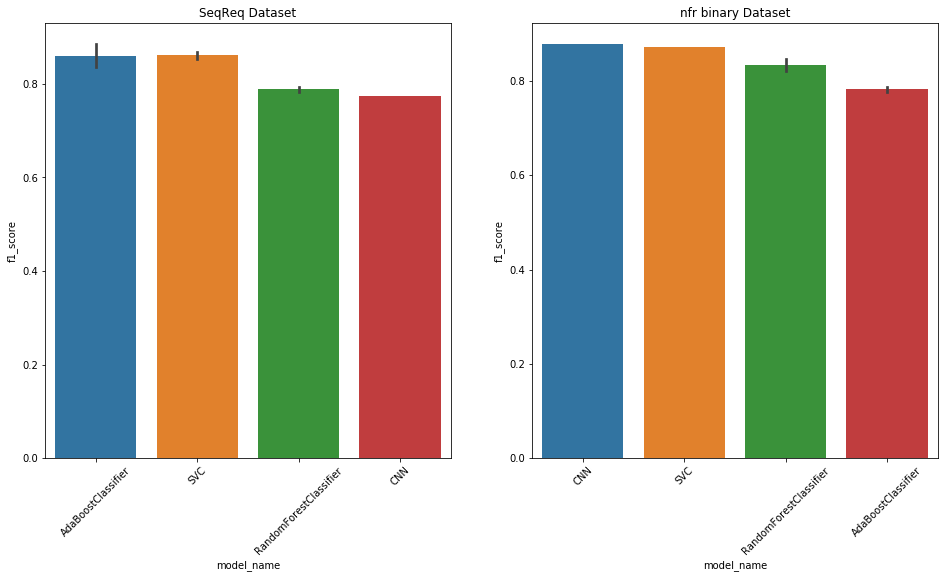

In [171]:
## Plots- Binary classification model comparisions
fig, axes = plt.subplots(1,2,figsize=(16,8))
p1= sns.barplot(x="model_name", y="f1_score",  data= binary_results_all[binary_results_all.dataset=="SecReq"], 
                ax=axes[0])
p2 = sns.barplot(x="model_name", y="f1_score", data=binary_results_all[binary_results_all.dataset=="nfr_binary"], 
                 ax=axes[1])

axes[0].title.set_text('SeqReq Dataset')
axes[1].title.set_text('nfr binary Dataset')

p1.set_xticklabels(p1.get_xticklabels(),rotation=45)
p2.set_xticklabels(p2.get_xticklabels(),rotation=45)

plt.savefig("../outputs/final_model_comparison/binary_classification_results_all.jpeg")

**Multiclass Classification Results**

In [180]:
multiclass_results_all = pd.concat([multiclass_results_trad,multiclass_results_cnn], axis= 0)
multiclass_results_all= multiclass_results_all.sort_values("f1_score", ascending= False)
multiclass_results_all.to_csv("../outputs/final_model_comparison/multiclass_classification_results.csv", index=False)

In [181]:
multiclass_results_all

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
0,nfr,pre_trained_wv,CNN,0.756757,0.814216,0.748480,0.761516
0,nfr,tfidf,SVC,0.738739,0.796898,0.723694,0.744453
1,nfr,tfidf,RandomForestClassifier,0.657658,0.764148,0.619862,0.641585
2,nfr,tfidf,AdaBoostClassifier,0.423423,0.535246,0.414067,0.393084


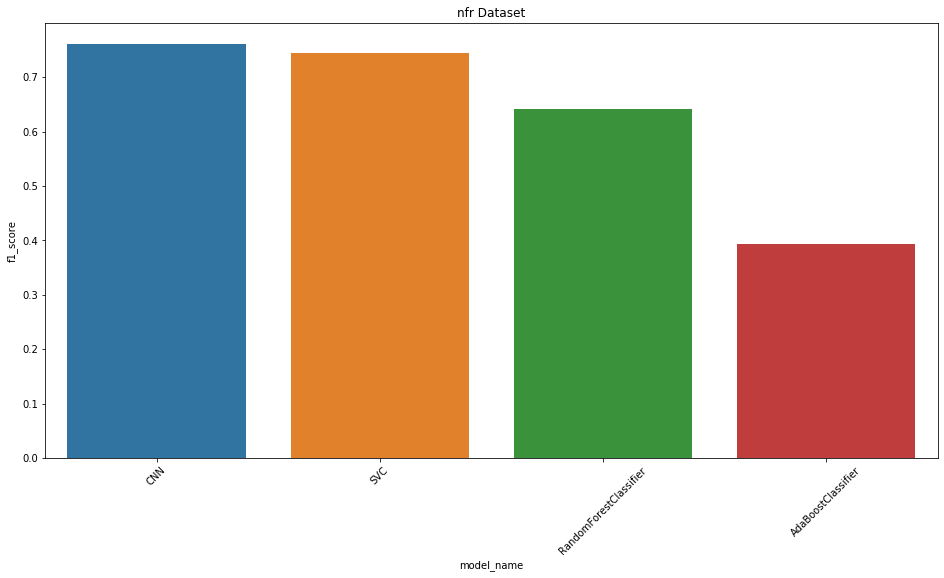

In [184]:
## Plots- Multiclass classification model comparisions
fig, axes = plt.subplots(1,1,figsize=(16,8))
p1= sns.barplot(x="model_name", y="f1_score",  data= multiclass_results_all, 
                ax=axes)
axes.title.set_text('nfr Dataset')
p1.set_xticklabels(p1.get_xticklabels(),rotation=45)


plt.savefig("../outputs/final_model_comparison/multiclass_classification_results_all.jpeg")

## Final Thoughts
- CNN with pre-trained word embeddings outperforms SVC, Random Forest and Adaboost classifiers in 2 out of the 3 classification tasks.
- For larger datasets, perhaps the performance difference would be wider.  One distinct advantage of CNN is that it automatically identify features that are informative in making predictions; thus, we don't have to learn the bigrams and trigrams engineer these features ourselves.
- All models require hyperparameters tuning, some more than others.
- SVC is a simple and the fastest model to train.  I would go with SVC in this case since its performance is almost as good as CNN and Adaboost.
- Pre-trained word embeddings compensate for the small amount of train data-- note that for the multiclass classification problem, I have less than 400 train observations to train my CNN!